http://modernstatisticalworkflow.blogspot.ch/2018/02/regime-switching-models-in-stan.html

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import quandl as quandl

import matplotlib.pyplot as plt
plt.style.use('seaborn-darkgrid')

In [2]:
googl = quandl.get("WIKI/GOOGL", collapse = "weekly")

In [3]:
googl = (googl.pipe(lambda x: x.assign(l_ac=np.log(x['Adj. Close'])))
              .pipe(lambda x: x.assign(dl_ac=np.hstack([np.nan, np.diff(x['l_ac'])])))
              .query('index > "2010-01-01"')
        )

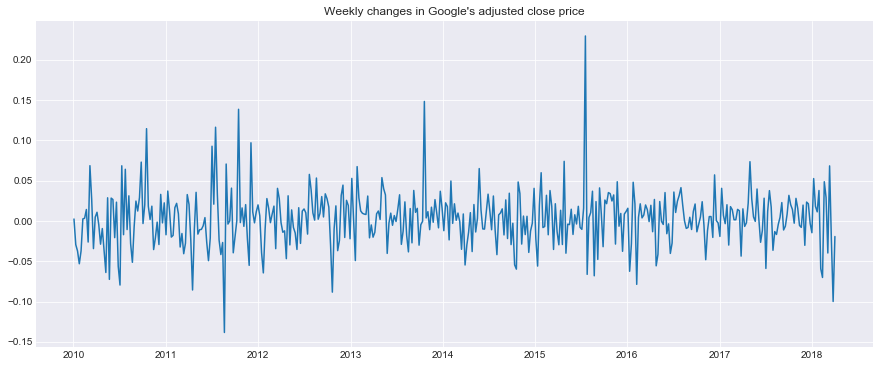

In [4]:
_, ax = plt.subplots(1, 1, figsize=(15, 6))
ax.plot(googl['dl_ac'])
ax.set_title("Weekly changes in Google's adjusted close price");

In [5]:
import pymc3 as pm
import theano.tensor as tt
import theano

In [6]:
T = googl.shape[0]
y = np.asarray(googl['dl_ac'])*100
yshared = theano.shared(y)

Test recurrent function that generates f and xi

In [7]:
theano.config.test_values = 'raise'

In [8]:
eta_ = tt.dmatrix("eta_")
eta0 = np.random.rand(100, 2)
eta_.tag.test_value = eta0

P = tt.dmatrix("P")
P0 = np.asarray([[.75, .25], [.25, .75]])
P.tag.test_value = P0
xi_ = tt.dscalar("xi_")
xi_.tag.test_value = .75
xi_out = tt.dscalar("xi_out")
xi_out.tag.test_value = 0
ft_out = tt.dscalar("ft_out")
ft_out.tag.test_value = 0

def ft_xit_dt(Eta, ft, Xi, P):
    Xi_ = tt.shape_padleft(Xi)
    xit0 = tt.stack([Xi_, 1 - Xi_], axis=1).T
    ft = tt.sum(tt.dot(xit0 * P, Eta))
    Xi1 = (P[0, 0] * Xi + P[1, 0] * (1 - Xi)) * Eta[0] / ft
    return [ft, Xi1]


([ft, xi], updates) = theano.scan(ft_xit_dt,
                                  sequences=eta_,
                                  outputs_info=[ft_out, xi_out],
                                  non_sequences=P)

ft_xit_dt_ = theano.function(inputs=[eta_, ft_out, xi_out, P], outputs=[ft, xi], updates=updates)

In [9]:
ft1, xi1 = ft_xit_dt_(eta0, 0, .75, P0)

In [10]:
ft2 = np.zeros(100)
xi2 = np.zeros(100)

ftfunc = lambda eta,xi: P0[0, 0]*xi*eta[0] +\
                        P0[0, 1]*xi*eta[1] +\
                        P0[1, 1]*(1 - xi)*eta[1] +\
                        P0[1, 0]*(1 - xi)*eta[0]
Eta = eta0[0]
Xi_ = np.asarray([.75])
ft2[0] = ftfunc(Eta, Xi_)
xi2[0] = (P0[0, 0] * Xi_ + P0[1, 0] * (1 - Xi_)) * Eta[0] / ft2[0]


for i in range(1, 100):
    Eta = eta0[i]
    Xi_ = xi2[i - 1]
    ft2[i] = ftfunc(Eta, Xi_)
    xi2[i] = (P0[0, 0] * Xi_ + P0[1, 0] * (1 - Xi_)) * Eta[0] / ft2[i]

In [11]:
np.testing.assert_almost_equal(ft1, ft2)
np.testing.assert_almost_equal(xi1, xi2)

The scan function is fine, to the next step:

Random walk with Markov transition

In [12]:
with pm.Model() as m:
    # Transition matrix
    p = pm.Beta('p', alpha=10., beta=2., shape=2)
    P = tt.diag(p)
    P = tt.set_subtensor(P[0, 1], 1 - p[0])
    P = tt.set_subtensor(P[1, 0], 1 - p[1])

    # eta
    alpha = pm.Normal('alpha', mu=0., sd=.1, shape=2)
    sigma = pm.HalfCauchy('sigma', beta=1., shape=2)
    eta1 = tt.exp(pm.Normal.dist(mu=alpha[0], sd=sigma[0]).logp(yshared))

    y_tm1_init = pm.Normal('y_init', mu=0., sd=.1)
    pNormal = pm.Bound(pm.Normal, lower=0.0)
    rho = pNormal('rho', mu=1.0, sd=.1, testval=1.0)
    eta2 = tt.zeros_like(eta1)
    eta2 = tt.set_subtensor(eta2[0], tt.exp(
        pm.Normal.dist(mu=alpha[1] + rho * y_tm1_init, sd=sigma[1]).logp(yshared[0])))
    eta2 = tt.set_subtensor(eta2[1:], tt.exp(
        pm.Normal.dist(mu=alpha[1] + rho * yshared[:-1], sd=sigma[1]).logp(yshared[1:])))

    eta = tt.stack([eta1, eta2], axis=1)

    xi_init = pm.Beta('xi_init', alpha=2., beta=2.)
    ft_out = theano.shared(0.) # place holder
    ([ft, xi], updates) = theano.scan(ft_xit_dt,
                                      sequences=eta,
                                      outputs_info=[ft_out, xi_init],
                                      non_sequences=P)

    Xi = pm.Deterministic('Xi', xi)
    # likelihood `target += sum(log(f))`
    pm.Potential('likelihood', tt.sum(tt.log(ft)))

/home/junpenglao/anaconda3/lib/python3.7/site-packages/Theano-1.0.4-py3.7.egg/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x


In [13]:
with m:
    trace = pm.sample(1000, tune=1000, cores=4, init="adapt_diag")

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
/home/junpenglao/anaconda3/lib/python3.7/site-packages/Theano-1.0.4-py3.7.egg/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [xi_init, rho, y_init, sigma, alpha, p]
/home/junpenglao/anaconda3/lib/python3.7/site-packages/Theano-1.0.4-py3.7.egg/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x


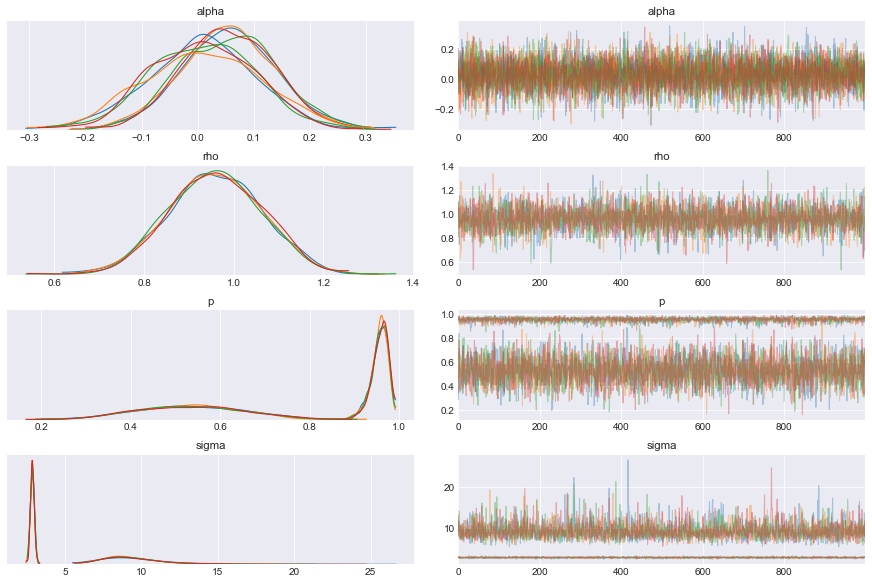

In [14]:
pm.traceplot(trace, var_names=['alpha', 'rho', 'p', 'sigma']);

In [17]:
df = pm.summary(trace, var_names=['alpha', 'rho', 'p', 'sigma'])
df.round(2)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
alpha[0],0.06,0.08,-0.10,0.22,0.00,0.00,5298.0,2678.0,5312.0,2824.0,1.0
alpha[1],0.01,0.10,-0.17,0.19,0.00,0.00,5045.0,1895.0,5003.0,2646.0,1.0
rho,0.96,0.10,0.77,1.15,0.00,0.00,5452.0,5452.0,5527.0,2813.0,1.0
p[0],0.96,0.02,0.92,0.99,0.00,0.00,3228.0,3228.0,3344.0,2615.0,1.0
p[1],0.53,0.12,0.32,0.75,0.00,0.00,4631.0,4321.0,4641.0,3104.0,1.0
sigma[0],2.87,0.13,2.63,3.12,0.00,0.00,4554.0,4554.0,4566.0,3172.0,1.0
sigma[1],9.44,2.05,6.29,13.29,0.04,0.03,3531.0,3123.0,4334.0,2809.0,1.0


Compare with Stan fit:
```
## Inference for Stan model: regime_switching_model.
## 4 chains, each with iter=1000; warmup=500; thin=1; 
## post-warmup draws per chain=500, total post-warmup draws=2000.
## 
##          mean se_mean   sd  2.5%   25%  50%   75% 97.5% n_eff Rhat
## alpha[1] 0.06    0.00 0.08 -0.10  0.00 0.06  0.11  0.21  2000    1
## alpha[2] 0.01    0.00 0.10 -0.20 -0.06 0.01  0.07  0.21  2000    1
## rho      0.96    0.00 0.10  0.76  0.89 0.96  1.03  1.16  2000    1
## p[1]     0.96    0.00 0.02  0.92  0.95 0.96  0.97  0.99  2000    1
## p[2]     0.54    0.00 0.12  0.31  0.46 0.55  0.63  0.77  2000    1
## sigma[1] 2.85    0.00 0.13  2.59  2.77 2.85  2.94  3.10  2000    1
## sigma[2] 9.69    0.06 2.26  6.56  8.15 9.24 10.76 15.31  1672    1
## 
## Samples were drawn using NUTS(diag_e) at Wed Feb 28 11:22:52 2018.
## For each parameter, n_eff is a crude measure of effective sample size,
## and Rhat is the potential scale reduction factor on split chains (at 
## convergence, Rhat=1).
```

In [18]:
xi_post = trace['Xi']
xilo, xihi = np.percentile(xi_post, [2.5, 97.5], axis=0)
googl = (googl.assign(xipost = xi_post.mean(axis=0))
              .assign(xilower = xilo)
              .assign(xihigher = xihi)
        )

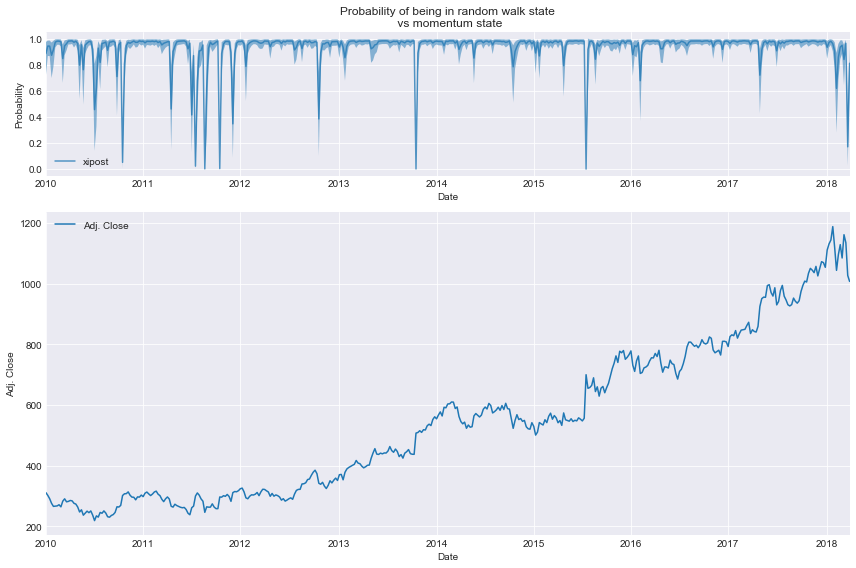

In [19]:
fig = plt.figure(figsize=(12, 8))
ax1 = plt.subplot2grid((3, 1), (0, 0), fig=fig)
ax2 = plt.subplot2grid((3, 1), (1, 0), fig=fig, rowspan=2)

googl.plot(y='xipost', alpha=.75, ax=ax1,
           title="Probability of being in random walk state\n vs momentum state")
ax1.fill_between(googl.index, googl.xilower, googl.xihigher, alpha=.5)
ax1.set_ylabel('Probability')
googl.plot(y='Adj. Close', ax=ax2)
ax2.set_ylabel('Adj. Close')
plt.tight_layout();